In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
import pandas as pd
PRIMARY = 'Category Name'
SECONDARY = 'Customer State'

df = pd.read_csv(
    'DataCoSupplyChainDataset.csv', 
    usecols = [PRIMARY, SECONDARY], 
    encoding = 'unicode_escape'
).apply(lambda col: col.str.strip())
df.head()

,Category Name,Customer State
0,Sporting Goods,PR
1,Sporting Goods,PR
2,Sporting Goods,CA
3,Sporting Goods,CA
4,Sporting Goods,PR


# Check & remove null + duplicate values

In [3]:
df.isnull().sum().sort_values(ascending=False)

Category Name     0
Customer State    0
dtype: int64

In [4]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 170097
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category Name   1751 non-null   object
 1   Customer State  1751 non-null   object
dtypes: object(2)
memory usage: 41.0+ KB


# Convert DataFrame to Graphs

In [5]:
primary_col, secondary_col = df[PRIMARY], df[SECONDARY]
print(f'Number of {PRIMARY}:', primary_col.nunique())
print(f'Number of {SECONDARY}:', secondary_col.nunique())
print('Number of edges:', len(df))

Number of Category Name: 50
Number of Customer State: 46
Number of edges: 1751


## 1. Bipartite Graph

In [6]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()
for index, row in df.iterrows():
    B.add_edge(row[PRIMARY], row[SECONDARY], weight=1)

B.add_nodes_from(primary_col, bipartite=0)
B.add_nodes_from(secondary_col, bipartite=1)    

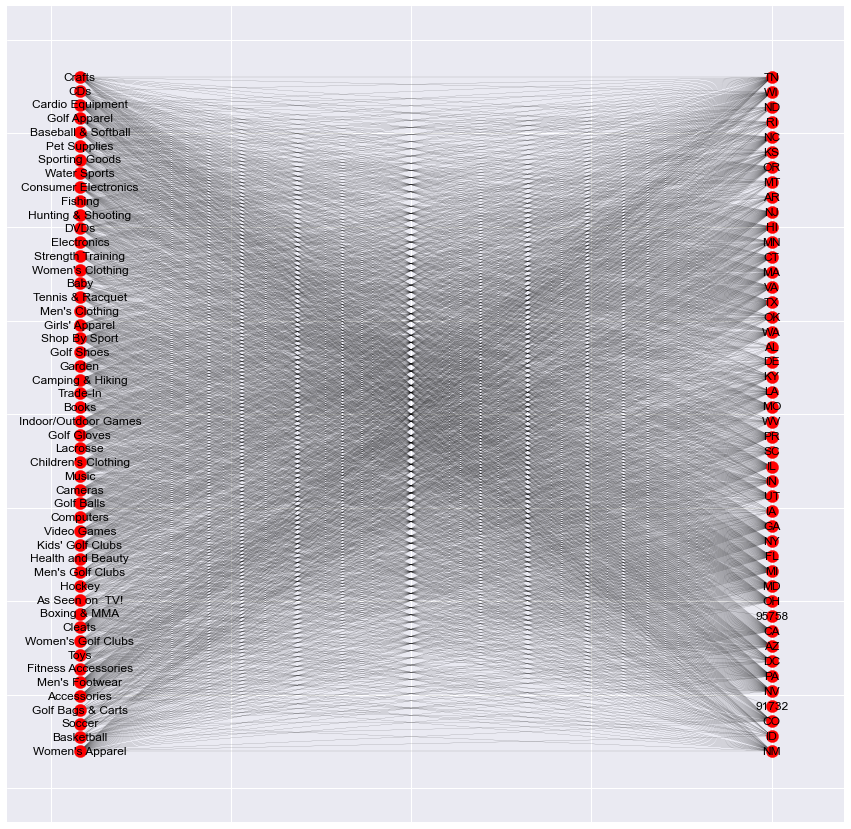

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
pos = nx.drawing.layout.bipartite_layout(B, primary_col)
nx.draw_networkx(B, pos=pos, node_size=150, width=0.1, node_color='red')

## 2. Weighted Projected Graph

In [8]:
G = bipartite.weighted_projected_graph(B, primary_col)
node_labels = dict(zip(primary_col, primary_col))

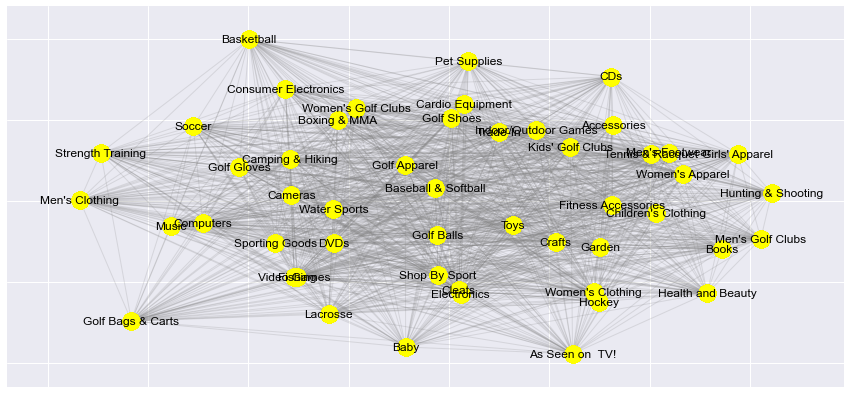

In [9]:
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=primary_col, node_color='yellow')
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Community Detection

In [10]:
df_groupby_category = df.groupby([SECONDARY])[PRIMARY].apply(lambda x: sorted(set(x)))
df_groupby_category = df_groupby_category.reset_index()
# print(df_groupby_category.iloc[14][1])
df_groupby_category.head()

,Customer State,Category Name
0,91732,[Children's Clothing]
1,95758,"[Consumer Electronics, Video Games]"
2,AL,"[Camping & Hiking, Cardio Equipment, Cleats, C..."
3,AR,"[Cameras, Camping & Hiking, Cardio Equipment, ..."
4,AZ,"[Accessories, Baby, Baseball & Softball, Baske..."


In [11]:
def get_cluster_common_values(cluster):
    commons = []
    for index, row in df_groupby_category.iterrows():
        if set(cluster).issubset(row[PRIMARY]):
            commons.append(row[SECONDARY])
    return commons

In [12]:
def print_communities(node_groups):
    print('Number of communities:', len(node_groups))
    for index, cluster in enumerate(node_groups):
        common_values = get_cluster_common_values(cluster)
        print(f'\nCluster {index}:')
        print(f"- {len(cluster)} Nodes: {', '.join(cluster)}")
        print(f"- {len(common_values)} Common values: {', '.join(common_values)}")

## 1. Louvain Algorithm

In [13]:
import community.community_louvain as community_louvain
from collections import defaultdict
partition = community_louvain.best_partition(G)
louvain_node_groups = [[] for _ in set(partition.values())]

for node, cluster in sorted(partition.items()):
    louvain_node_groups[cluster].append(node)
print_communities(louvain_node_groups)

Number of communities: 2

Cluster 0:
- 25 Nodes: Accessories, Books, Cameras, Camping & Hiking, Cardio Equipment, Children's Clothing, Cleats, Computers, Consumer Electronics, Crafts, Electronics, Fishing, Garden, Golf Apparel, Golf Balls, Golf Gloves, Golf Shoes, Indoor/Outdoor Games, Kids' Golf Clubs, Men's Footwear, Shop By Sport, Video Games, Water Sports, Women's Apparel, Women's Clothing
- 23 Common values: AZ, CA, CO, CT, FL, GA, HI, IL, LA, MA, MD, MI, MO, NC, NJ, NV, NY, OH, OR, PA, PR, TN, TX

Cluster 1:
- 25 Nodes: As Seen on  TV!, Baby, Baseball & Softball, Basketball, Boxing & MMA, CDs, DVDs, Fitness Accessories, Girls' Apparel, Golf Bags & Carts, Health and Beauty, Hockey, Hunting & Shooting, Lacrosse, Men's Clothing, Men's Golf Clubs, Music, Pet Supplies, Soccer, Sporting Goods, Strength Training, Tennis & Racquet, Toys, Trade-In, Women's Golf Clubs
- 8 Common values: CA, FL, GA, IL, MI, NY, PR, TX


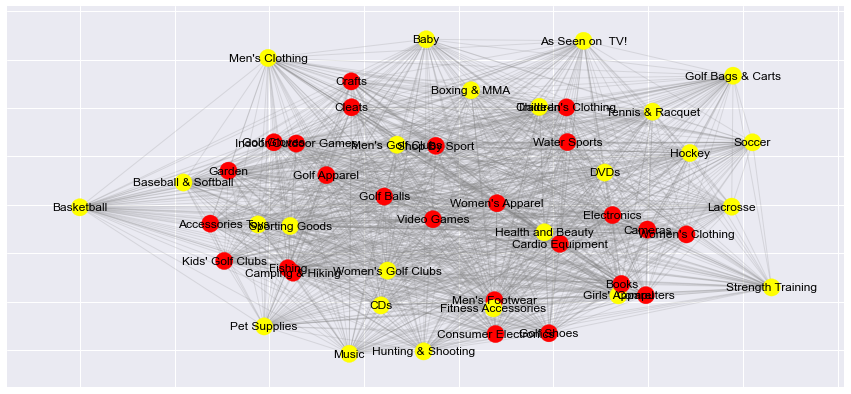

In [14]:
import matplotlib.cm as cm
cmap = cm.get_cmap('autumn', max(partition.values()) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, partition.keys(), cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

## 2. Girvan Newman Algorithm

In [15]:
from networkx.algorithms.community.centrality import girvan_newman
communities = girvan_newman(G)
gn_node_groups = []

for com in next(communities):
    gn_node_groups.append(sorted(com))
print_communities(gn_node_groups)

Number of communities: 2

Cluster 0:
- 1 Nodes: Sporting Goods
- 31 Common values: AZ, CA, CO, CT, DE, FL, GA, HI, IL, IN, LA, MA, MD, MI, MN, MO, MT, NC, ND, NJ, NY, OH, OR, PA, PR, TN, TX, UT, VA, WA, WI

Cluster 1:
- 49 Nodes: Accessories, As Seen on  TV!, Baby, Baseball & Softball, Basketball, Books, Boxing & MMA, CDs, Cameras, Camping & Hiking, Cardio Equipment, Children's Clothing, Cleats, Computers, Consumer Electronics, Crafts, DVDs, Electronics, Fishing, Fitness Accessories, Garden, Girls' Apparel, Golf Apparel, Golf Bags & Carts, Golf Balls, Golf Gloves, Golf Shoes, Health and Beauty, Hockey, Hunting & Shooting, Indoor/Outdoor Games, Kids' Golf Clubs, Lacrosse, Men's Clothing, Men's Footwear, Men's Golf Clubs, Music, Pet Supplies, Shop By Sport, Soccer, Strength Training, Tennis & Racquet, Toys, Trade-In, Video Games, Water Sports, Women's Apparel, Women's Clothing, Women's Golf Clubs
- 8 Common values: CA, FL, GA, IL, MI, NY, PR, TX


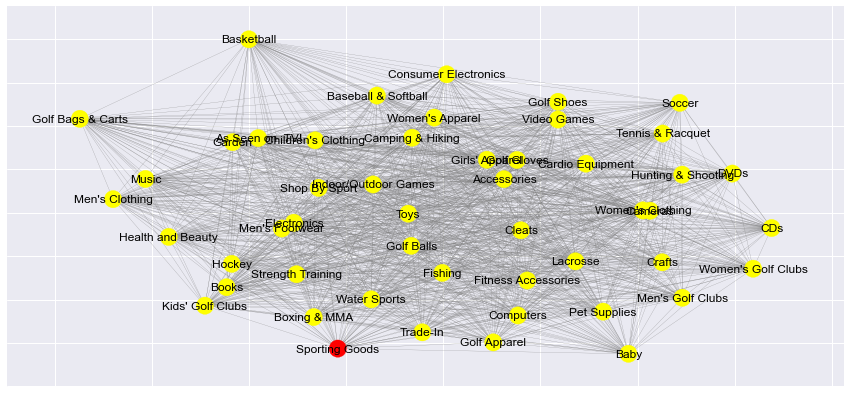

In [16]:
color_map = []    
for node in G:
    color_map.append('red' if node in gn_node_groups[0] else 'yellow')
    
plt.figure(figsize=(15, 7))    
nx.draw_networkx(G, node_color=color_map, edge_color='grey', width=0.2)
plt.show()

## 3. K-Means Algorithm

In [17]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
adj_matrix = nx.to_numpy_array(G)
adj_matrix

array([[ 0., 31., 31., ..., 30., 31., 31.],
       [31.,  0., 44., ..., 35., 44., 44.],
       [31., 44.,  0., ..., 35., 44., 44.],
       ...,
       [30., 35., 35., ...,  0., 35., 35.],
       [31., 44., 44., ..., 35.,  0., 44.],
       [31., 44., 44., ..., 35., 44.,  0.]])

In [18]:
import numpy as np
distortions = []
K = range(1, 8)

for k in K:
    kmean_model = KMeans(n_clusters=k)
    kmean_model.fit(adj_matrix)
    dist = sum(np.min(cdist(adj_matrix, kmean_model.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(dist / adj_matrix.shape[0])

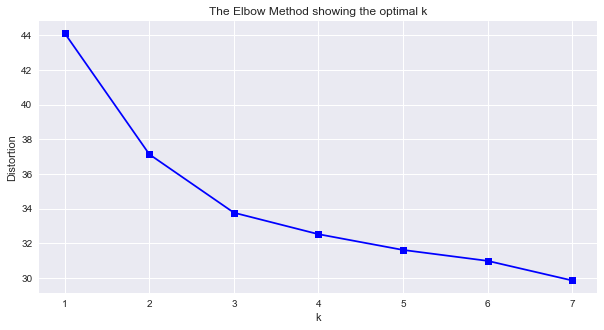

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bs-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(adj_matrix)
kmeans_node_groups = [[] for _ in range(kmeans.n_clusters)]
 
for node, cluster in zip(G.nodes(), kmeans.labels_):
    kmeans_node_groups[cluster].append(node)
print_communities(kmeans_node_groups)

Number of communities: 3

Cluster 0:
- 23 Nodes: Sporting Goods, Boxing & MMA, Trade-In, Kids' Golf Clubs, Hunting & Shooting, Baseball & Softball, Consumer Electronics, Soccer, Crafts, Tennis & Racquet, Fitness Accessories, Lacrosse, Books, DVDs, CDs, Hockey, Pet Supplies, Health and Beauty, Music, Golf Apparel, Women's Golf Clubs, Men's Golf Clubs, Toys
- 16 Common values: AZ, CA, CO, FL, GA, IL, MA, MI, NC, NJ, NY, OH, OR, PA, PR, TX

Cluster 1:
- 21 Nodes: Cleats, Shop By Sport, Women's Apparel, Electronics, Cardio Equipment, Men's Footwear, Camping & Hiking, Cameras, Computers, Girls' Apparel, Accessories, Women's Clothing, Golf Balls, Children's Clothing, Fishing, Garden, Video Games, Golf Gloves, Golf Shoes, Water Sports, Indoor/Outdoor Games
- 28 Common values: AZ, CA, CO, CT, FL, GA, HI, IL, IN, LA, MA, MD, MI, MN, MO, NC, NJ, NV, NY, OH, OR, PA, PR, TN, TX, VA, WA, WI

Cluster 2:
- 6 Nodes: Basketball, Men's Clothing, As Seen on  TV!, Strength Training, Baby, Golf Bags & Cart

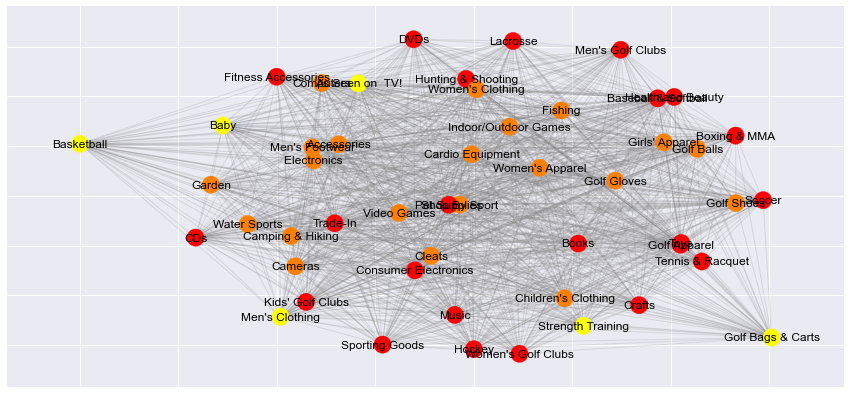

In [21]:
cmap = cm.get_cmap('autumn', max(kmeans.labels_) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, G.nodes(), cmap=cmap, node_color=kmeans.labels_)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

# Network Centrality

In [22]:
# Degree Centrality
degree = nx.degree(G)
degree_result = pd.DataFrame(degree, columns=['Category Name', 'Degree'])
degree_result.sort_values('Degree', ascending=False, inplace=True)

print(degree)
degree_result.head()

[('Sporting Goods', 49), ('Cleats', 49), ('Shop By Sport', 49), ("Women's Apparel", 49), ('Electronics', 49), ('Boxing & MMA', 49), ('Cardio Equipment', 49), ('Trade-In', 49), ("Kids' Golf Clubs", 49), ('Hunting & Shooting', 49), ('Baseball & Softball', 49), ("Men's Footwear", 49), ('Camping & Hiking', 49), ('Consumer Electronics', 49), ('Cameras', 49), ('Computers', 49), ('Basketball', 49), ('Soccer', 49), ("Girls' Apparel", 49), ('Accessories', 49), ("Women's Clothing", 49), ('Crafts', 49), ("Men's Clothing", 49), ('Tennis & Racquet', 49), ('Fitness Accessories', 49), ('As Seen on  TV!', 49), ('Golf Balls', 49), ('Strength Training', 49), ("Children's Clothing", 49), ('Lacrosse', 49), ('Baby', 49), ('Fishing', 49), ('Books', 49), ('DVDs', 49), ('CDs', 49), ('Garden', 49), ('Hockey', 49), ('Pet Supplies', 49), ('Health and Beauty', 49), ('Music', 49), ('Video Games', 49), ('Golf Gloves', 49), ('Golf Bags & Carts', 49), ('Golf Shoes', 49), ('Golf Apparel', 49), ("Women's Golf Clubs", 4

,Category Name,Degree
0,Sporting Goods,49
37,Pet Supplies,49
27,Strength Training,49
28,Children's Clothing,49
29,Lacrosse,49


In [23]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(G)
betweenness_result = pd.DataFrame(betweenness.items(), columns=['Category Name', 'Betweenness Centrality'])
betweenness_result.sort_values('Betweenness Centrality', ascending=False, inplace=True)

print(betweenness)
betweenness_result.head()

{'Sporting Goods': 0.0, 'Cleats': 0.0, 'Shop By Sport': 0.0, "Women's Apparel": 0.0, 'Electronics': 0.0, 'Boxing & MMA': 0.0, 'Cardio Equipment': 0.0, 'Trade-In': 0.0, "Kids' Golf Clubs": 0.0, 'Hunting & Shooting': 0.0, 'Baseball & Softball': 0.0, "Men's Footwear": 0.0, 'Camping & Hiking': 0.0, 'Consumer Electronics': 0.0, 'Cameras': 0.0, 'Computers': 0.0, 'Basketball': 0.0, 'Soccer': 0.0, "Girls' Apparel": 0.0, 'Accessories': 0.0, "Women's Clothing": 0.0, 'Crafts': 0.0, "Men's Clothing": 0.0, 'Tennis & Racquet': 0.0, 'Fitness Accessories': 0.0, 'As Seen on  TV!': 0.0, 'Golf Balls': 0.0, 'Strength Training': 0.0, "Children's Clothing": 0.0, 'Lacrosse': 0.0, 'Baby': 0.0, 'Fishing': 0.0, 'Books': 0.0, 'DVDs': 0.0, 'CDs': 0.0, 'Garden': 0.0, 'Hockey': 0.0, 'Pet Supplies': 0.0, 'Health and Beauty': 0.0, 'Music': 0.0, 'Video Games': 0.0, 'Golf Gloves': 0.0, 'Golf Bags & Carts': 0.0, 'Golf Shoes': 0.0, 'Golf Apparel': 0.0, "Women's Golf Clubs": 0.0, "Men's Golf Clubs": 0.0, 'Toys': 0.0, 'Wat

,Category Name,Betweenness Centrality
0,Sporting Goods,0.0
37,Pet Supplies,0.0
27,Strength Training,0.0
28,Children's Clothing,0.0
29,Lacrosse,0.0


In [24]:
# Closeness Centrality
closeness = nx.closeness_centrality(G)
closeness_result = pd.DataFrame(closeness.items(), columns=['Category Name', 'Closeness Centrality'])
closeness_result.sort_values('Closeness Centrality', ascending=False, inplace=True)

print(closeness)
closeness_result.head()

{'Sporting Goods': 1.0, 'Cleats': 1.0, 'Shop By Sport': 1.0, "Women's Apparel": 1.0, 'Electronics': 1.0, 'Boxing & MMA': 1.0, 'Cardio Equipment': 1.0, 'Trade-In': 1.0, "Kids' Golf Clubs": 1.0, 'Hunting & Shooting': 1.0, 'Baseball & Softball': 1.0, "Men's Footwear": 1.0, 'Camping & Hiking': 1.0, 'Consumer Electronics': 1.0, 'Cameras': 1.0, 'Computers': 1.0, 'Basketball': 1.0, 'Soccer': 1.0, "Girls' Apparel": 1.0, 'Accessories': 1.0, "Women's Clothing": 1.0, 'Crafts': 1.0, "Men's Clothing": 1.0, 'Tennis & Racquet': 1.0, 'Fitness Accessories': 1.0, 'As Seen on  TV!': 1.0, 'Golf Balls': 1.0, 'Strength Training': 1.0, "Children's Clothing": 1.0, 'Lacrosse': 1.0, 'Baby': 1.0, 'Fishing': 1.0, 'Books': 1.0, 'DVDs': 1.0, 'CDs': 1.0, 'Garden': 1.0, 'Hockey': 1.0, 'Pet Supplies': 1.0, 'Health and Beauty': 1.0, 'Music': 1.0, 'Video Games': 1.0, 'Golf Gloves': 1.0, 'Golf Bags & Carts': 1.0, 'Golf Shoes': 1.0, 'Golf Apparel': 1.0, "Women's Golf Clubs": 1.0, "Men's Golf Clubs": 1.0, 'Toys': 1.0, 'Wat

,Category Name,Closeness Centrality
0,Sporting Goods,1.0
37,Pet Supplies,1.0
27,Strength Training,1.0
28,Children's Clothing,1.0
29,Lacrosse,1.0


In [25]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G)
eigenvector_result = pd.DataFrame(eigenvector.items(), columns=['Category Name', 'Eigenvector Centrality'])
eigenvector_result.sort_values('Eigenvector Centrality', ascending=False, inplace=True)

print(eigenvector)
eigenvector_result.head()

{'Sporting Goods': 0.14142135623730948, 'Cleats': 0.14142135623730948, 'Shop By Sport': 0.14142135623730948, "Women's Apparel": 0.14142135623730948, 'Electronics': 0.14142135623730948, 'Boxing & MMA': 0.14142135623730948, 'Cardio Equipment': 0.14142135623730948, 'Trade-In': 0.14142135623730948, "Kids' Golf Clubs": 0.14142135623730948, 'Hunting & Shooting': 0.14142135623730948, 'Baseball & Softball': 0.14142135623730948, "Men's Footwear": 0.14142135623730948, 'Camping & Hiking': 0.14142135623730948, 'Consumer Electronics': 0.14142135623730948, 'Cameras': 0.14142135623730948, 'Computers': 0.14142135623730948, 'Basketball': 0.14142135623730948, 'Soccer': 0.14142135623730948, "Girls' Apparel": 0.14142135623730948, 'Accessories': 0.14142135623730948, "Women's Clothing": 0.14142135623730948, 'Crafts': 0.14142135623730948, "Men's Clothing": 0.14142135623730948, 'Tennis & Racquet': 0.14142135623730948, 'Fitness Accessories': 0.14142135623730948, 'As Seen on  TV!': 0.14142135623730948, 'Golf Ba

,Category Name,Eigenvector Centrality
0,Sporting Goods,0.141421
37,Pet Supplies,0.141421
27,Strength Training,0.141421
28,Children's Clothing,0.141421
29,Lacrosse,0.141421


In [26]:
# PageRank
pagerank = nx.pagerank(G)
pagerank_result = pd.DataFrame(pagerank.items(), columns=['Category Name', 'PageRank'])
pagerank_result.sort_values('PageRank', ascending=False, inplace=True)

print(pagerank)
pagerank_result.head()

{'Sporting Goods': 0.01866444202573307, 'Cleats': 0.022945993312615914, 'Shop By Sport': 0.022945993312615914, "Women's Apparel": 0.022945993312615914, 'Electronics': 0.022725924794572305, 'Boxing & MMA': 0.019495482624579827, 'Cardio Equipment': 0.022945993312615914, 'Trade-In': 0.02057689301068078, "Kids' Golf Clubs": 0.020247889863934502, 'Hunting & Shooting': 0.020596254456191117, 'Baseball & Softball': 0.02050233782559139, "Men's Footwear": 0.022945993312615914, 'Camping & Hiking': 0.022945993312615914, 'Consumer Electronics': 0.02058039664411369, 'Cameras': 0.02205207336029167, 'Computers': 0.02118833125078533, 'Basketball': 0.011825643549033581, 'Soccer': 0.017166897746086627, "Girls' Apparel": 0.021144896406385803, 'Accessories': 0.0223663688207117, "Women's Clothing": 0.02116939795269686, 'Crafts': 0.02027606482330599, "Men's Clothing": 0.015577762592565695, 'Tennis & Racquet': 0.019467619971334768, 'Fitness Accessories': 0.019506541776123713, 'As Seen on  TV!': 0.013674206590

,Category Name,PageRank
49,Indoor/Outdoor Games,0.022946
31,Fishing,0.022946
48,Water Sports,0.022946
3,Women's Apparel,0.022946
6,Cardio Equipment,0.022946
